In [1]:
import os
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
folder_path = "./aave_data/Core Market/"
core_crypto_csv = [ f for f in os.listdir(folder_path)]
print(core_crypto_csv)

['Tether.csv', 'USD Coin.csv', 'Wrapped BTC.csv', 'Wrapped ETH.csv']


In [6]:
core_crypto_dfs = { 
    f.lower().split('.')[0]: pd.read_csv(f) for f in core_crypto_csv 
}

In [7]:
for key, df in core_crypto_dfs.items():
    df['date-time'] = pd.to_datetime(df['date-time'])
    df['unix_date_time'] = df['date-time'].astype('int64') / 10**9

In [9]:
polyio_crypto = [f for f in os.listdir("./polyio_data/adjusted")]

In [11]:
polyio_dfs = { 
    f.lower().split('.')[0]: pd.read_csv(os.path.join("./polyio_data/adjusted", f)) 
    for f in polyio_crypto
}

for key, df in polyio_dfs.items():
    df['date-time'] = pd.to_datetime(df['date-time'])
    df['unix_date_time'] = df['date-time'].astype('int64') / 10 ** 9
    
polyio_dfs["btc"]

,Unnamed: 0,date-time,open_price,high_price,low_price,close_price,volume,unix_date_time
0,0,2023-03-14 00:00:00+00:00,24188.00,24364.60,24071.00,24275.71,1411.668208,1.678752e+09
1,1,2023-03-14 01:00:00+00:00,24274.87,24534.98,24195.00,24481.00,1280.805261,1.678756e+09
2,2,2023-03-14 02:00:00+00:00,24505.90,24597.00,24337.00,24380.52,1395.633094,1.678759e+09
3,3,2023-03-14 03:00:00+00:00,24380.52,24549.00,24300.00,24518.10,1179.926761,1.678763e+09
4,4,2023-03-14 04:00:00+00:00,24518.10,24600.00,24419.00,24575.21,1262.628515,1.678766e+09
...,...,...,...,...,...,...,...,...
17419,17419,2025-03-08 19:00:00+00:00,86007.30,86785.00,85760.72,86199.07,231.165228,1.741460e+09
17420,17420,2025-03-08 20:00:00+00:00,86201.80,86658.00,86158.56,86244.19,87.078983,1.741464e+09
17421,17421,2025-03-08 21:00:00+00:00,86302.30,86796.00,86149.00,86212.92,155.277140,1.741468e+09
17422,17422,2025-03-08 22:00:00+00:00,86199.30,86642.00,85838.48,86321.21,141.424795,1.741471e+09


In [152]:
def combine_on_unix_date_time(df1, df2):
    combined_df = pd.merge(df1, df2, on="unix_date_time", how="inner")
    cols = ['unix_date_time'] + [col for col in combined_df.columns if col != 'unix_date_time']
    combined_df = combined_df[cols]

    return combined_df

In [238]:
def plot_dual_y_axis(df, x, y1, y2, num_parts=1, window=1):
    df_copy = df.copy()
    split_indices = np.array_split(df_copy.index, num_parts) 

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, ax in enumerate(axes[:1]):
        df_part = df_copy.iloc[split_indices[i]] 

        ax.set_xlabel(x)
        ax.set_ylabel(y1, color='tab:blue')
        ax.plot(df_part[x], df_part[y1], color='tab:blue', linestyle='-', linewidth=1, label=y1)
        ax.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax.twinx()
        ax2.set_ylabel(y2, color='tab:red')
        ax2.plot(df_part[x], df_part[y2], color='tab:red', linestyle='-', linewidth=1, label=y2)
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax.set_title(f'No Smoothing: {y1} vs {y2} over {x}')

    if window > 1:
        df_copy[y1] = df_copy[y1].rolling(window=window, min_periods=1).mean()
        df_copy[y2] = df_copy[y2].rolling(window=window, min_periods=1).mean()

    for i, ax in enumerate(axes[1:]):
        df_part = df_copy.iloc[split_indices[i]] 

        ax.set_xlabel(x)
        ax.set_ylabel(y1, color='tab:blue')
        ax.plot(df_part[x], df_part[y1], color='tab:blue', linestyle='-', linewidth=1, label=y1)
        ax.tick_params(axis='y', labelcolor='tab:blue')

        ax2 = ax.twinx()
        ax2.set_ylabel(y2, color='tab:red')
        ax2.plot(df_part[x], df_part[y2], color='tab:red', linestyle='-', linewidth=1, label=y2)
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax.set_title(f'{window}hr Smoothing: {y1} vs {y2} over {x}')

    plt.tight_layout()
    plt.show()

In [241]:
df_pairs = [
    ('tether', 'usdt'),
    ('usd coin', 'usdc'),
    ('wrapped btc', 'btc'),
    ('wrapped eth', 'eth')
]

tether_core market


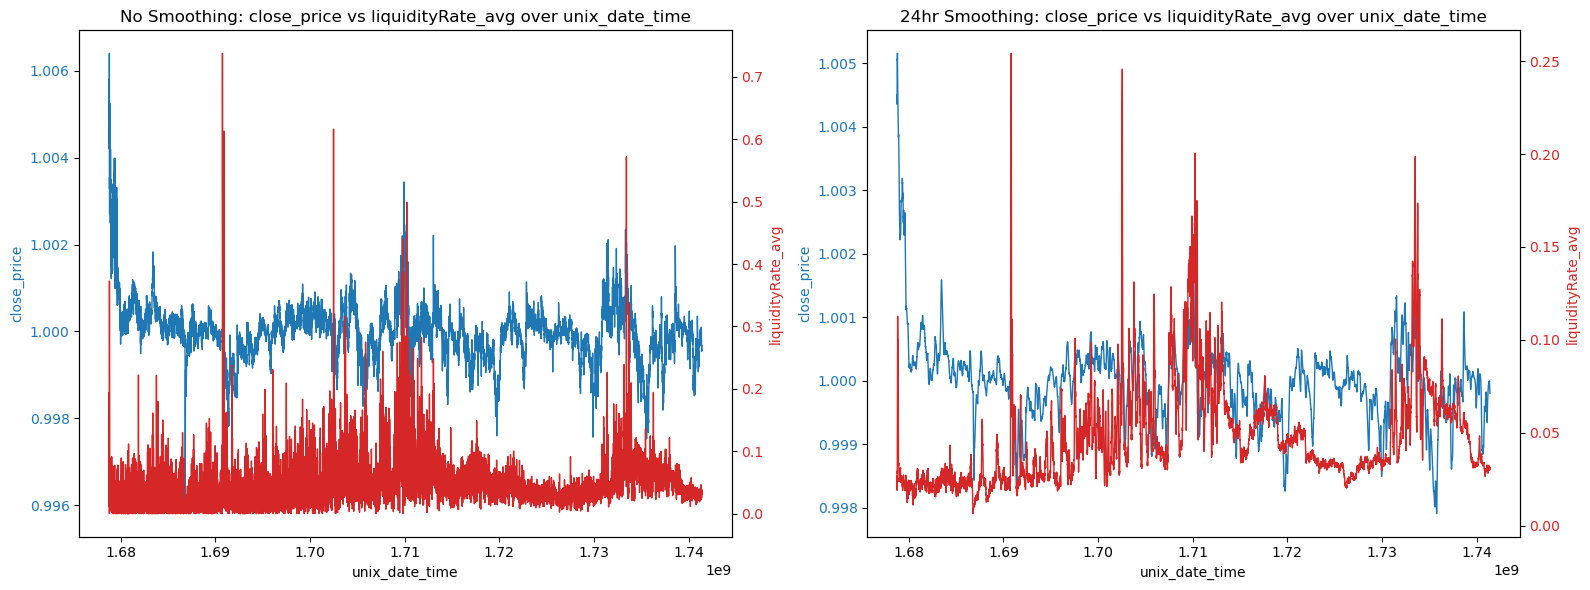

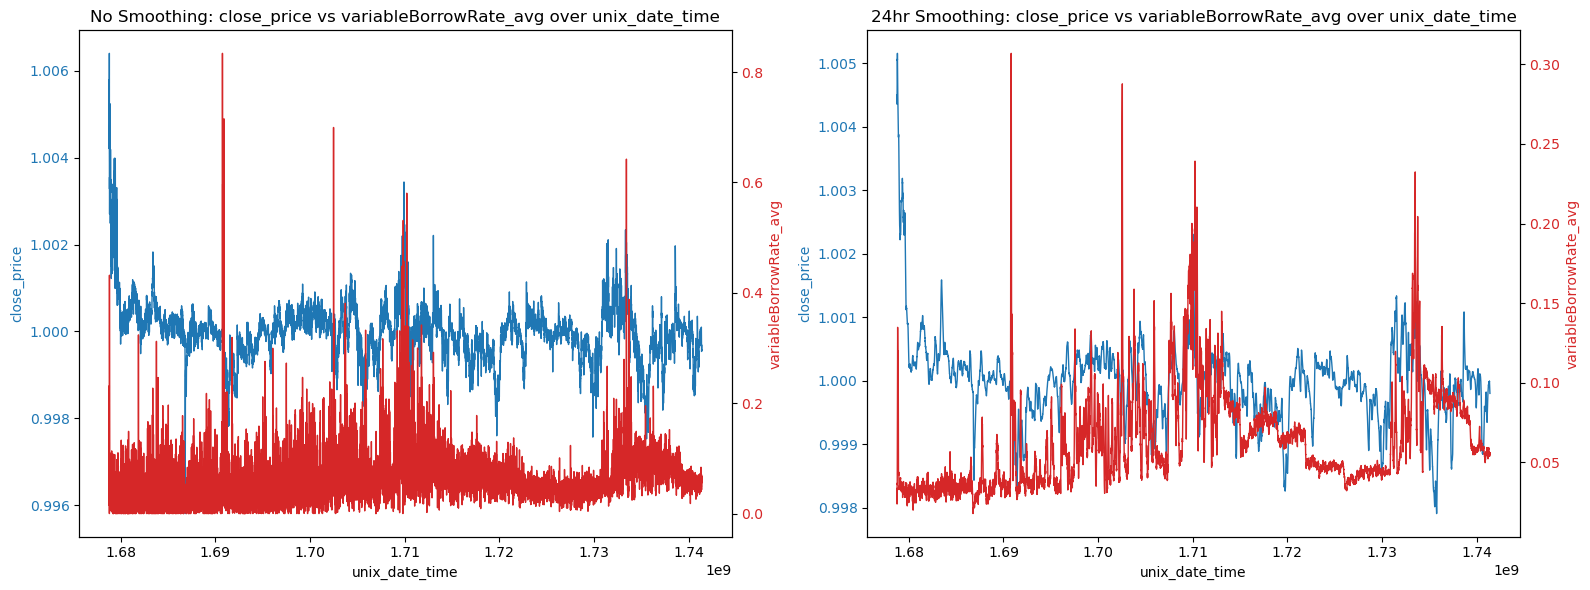

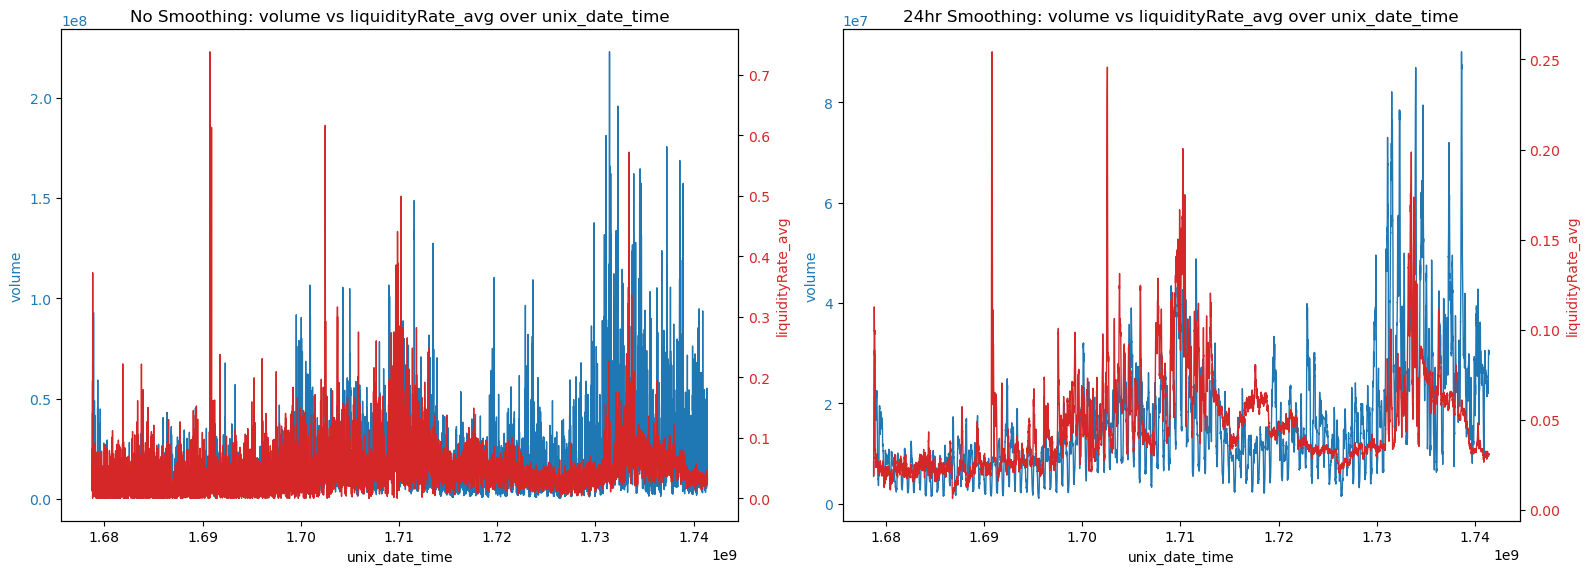

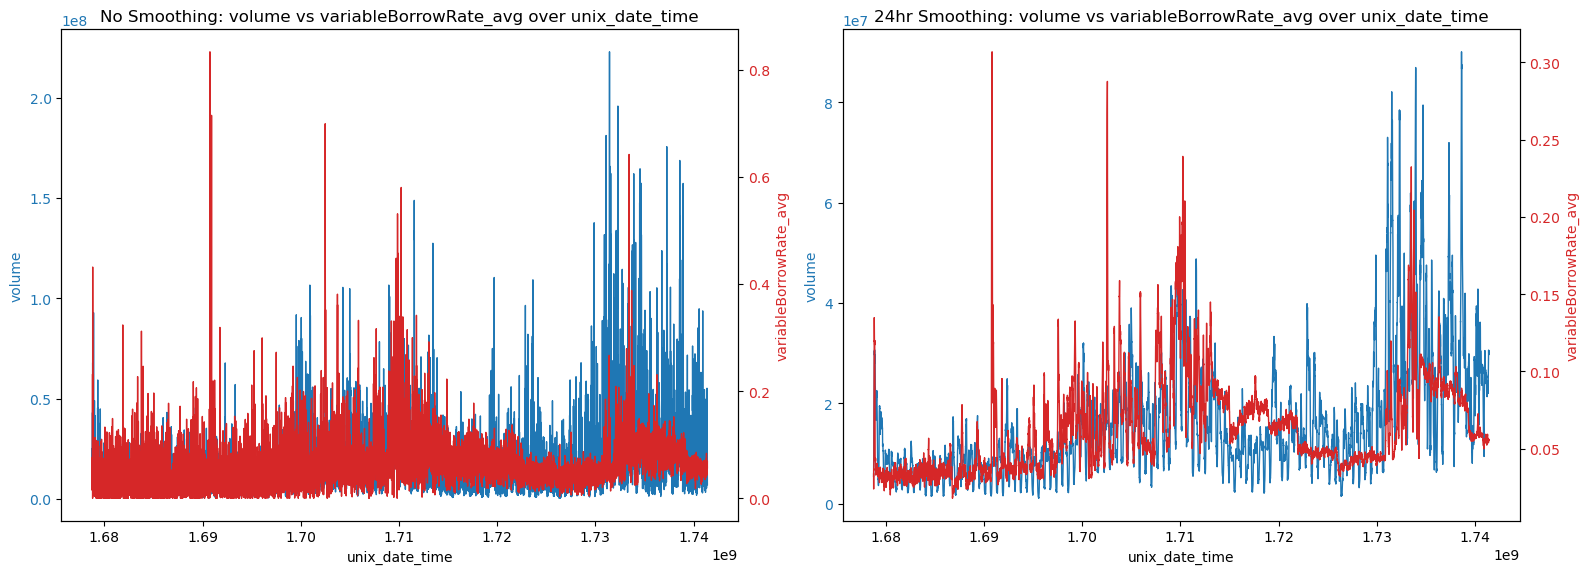

usd coin_core market


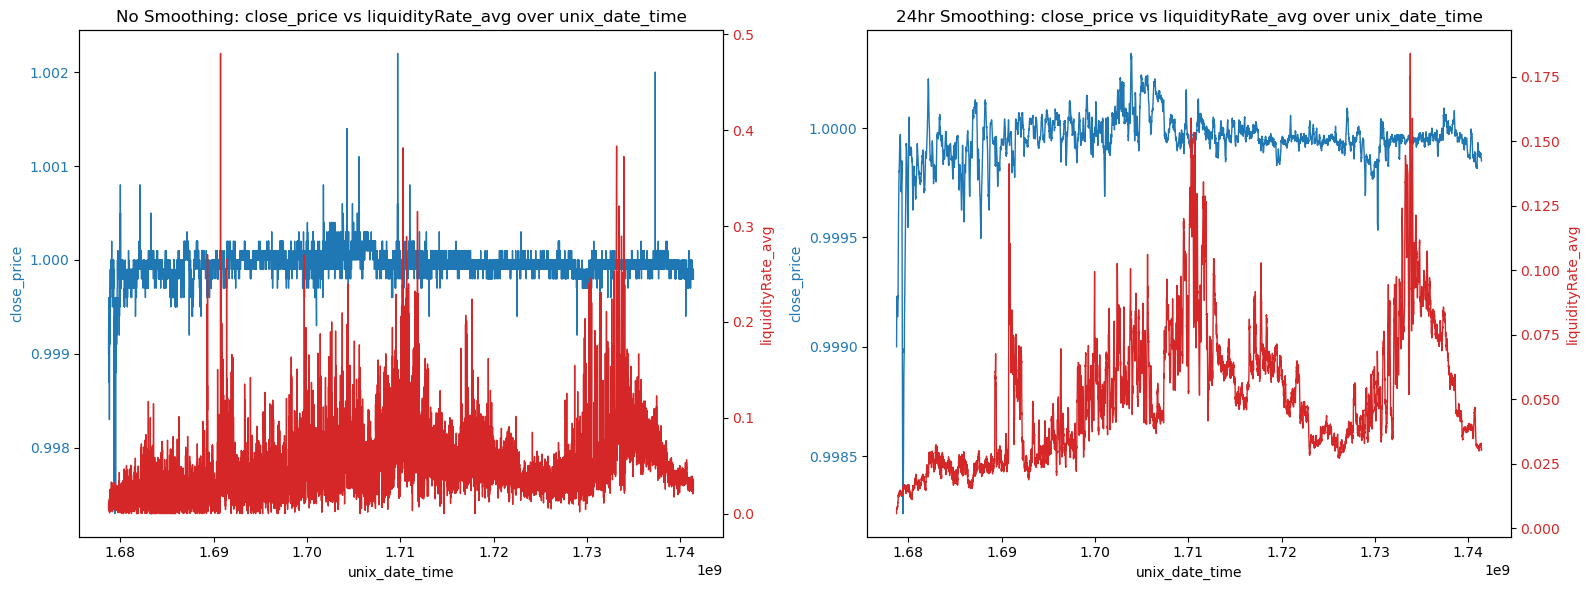

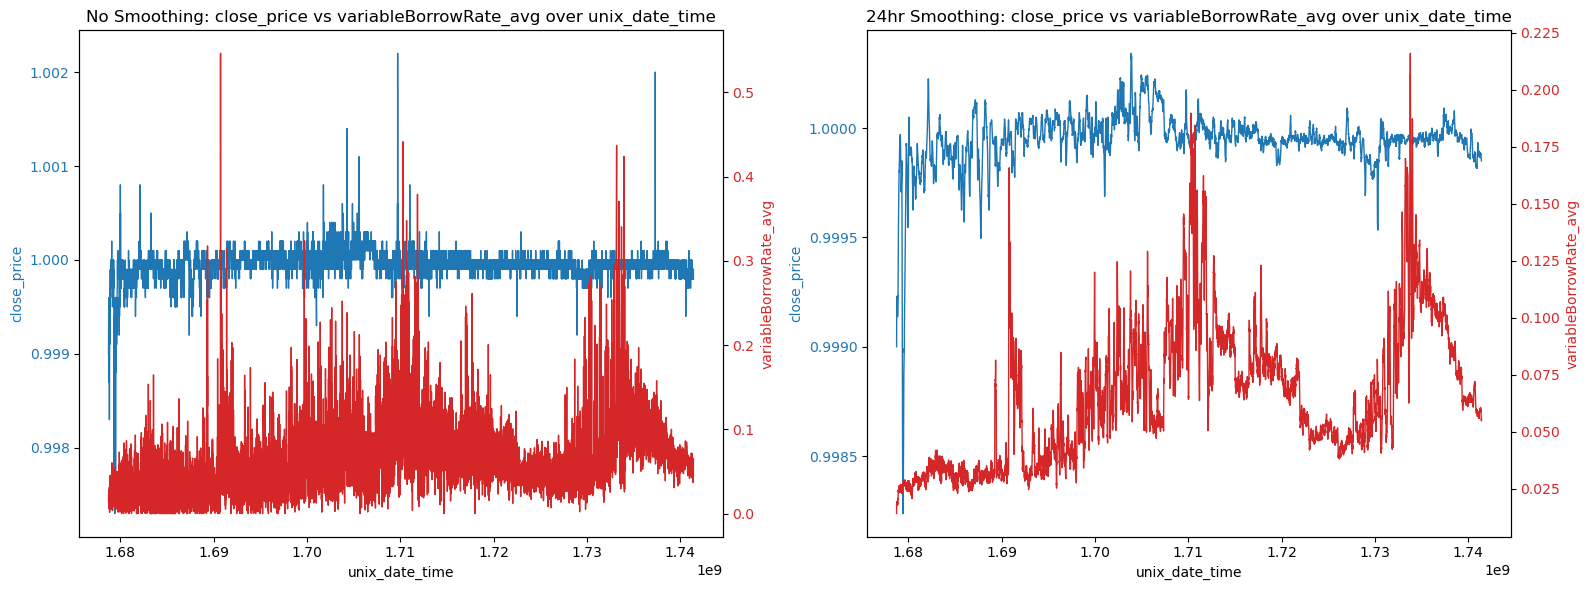

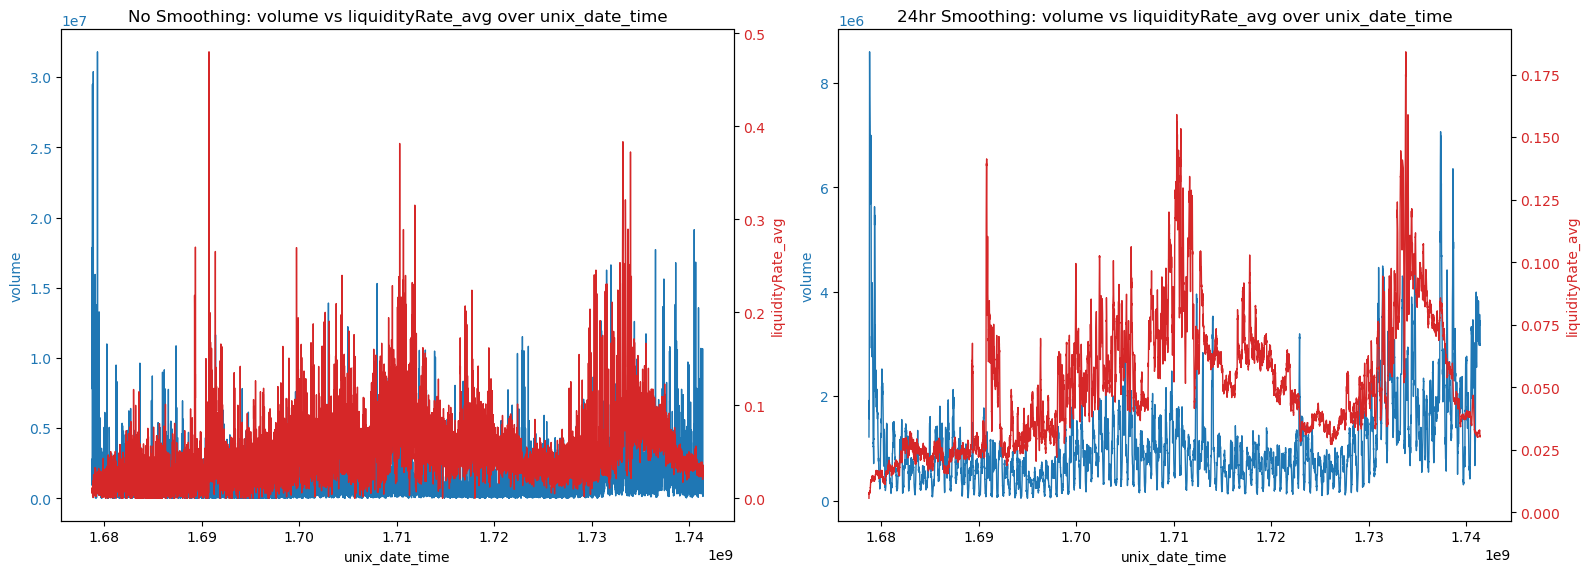

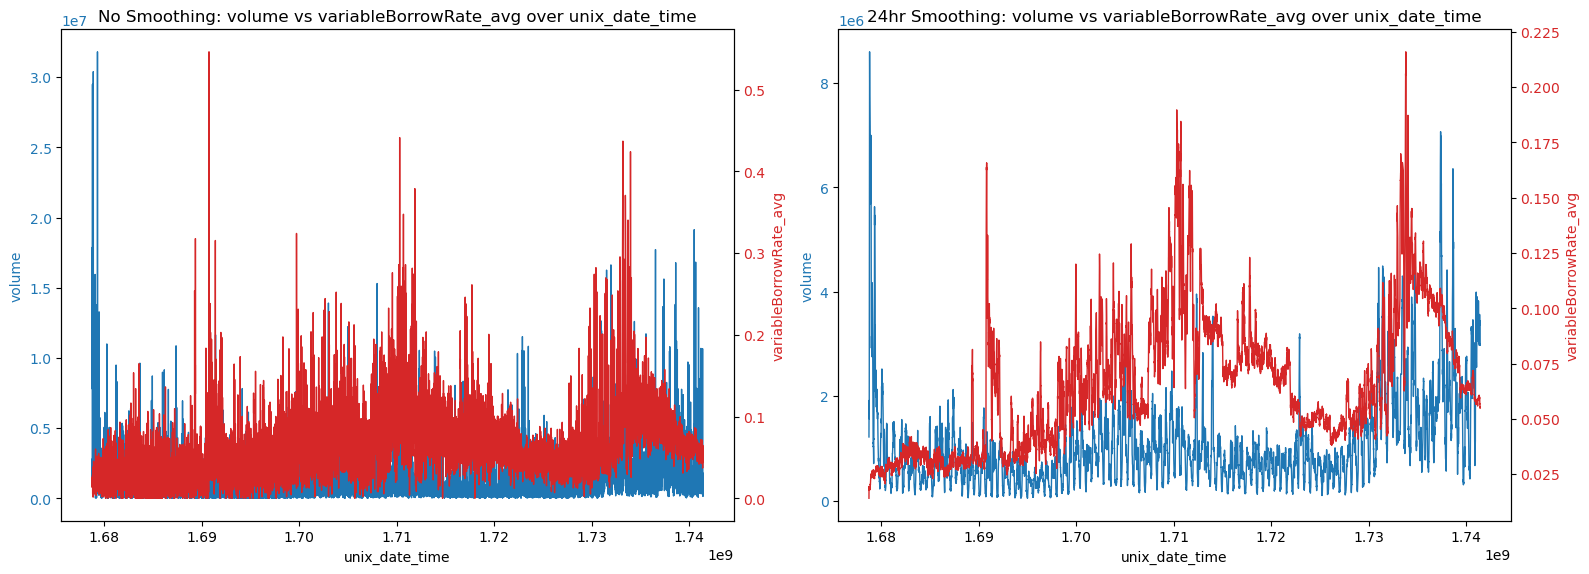

wrapped btc_core market


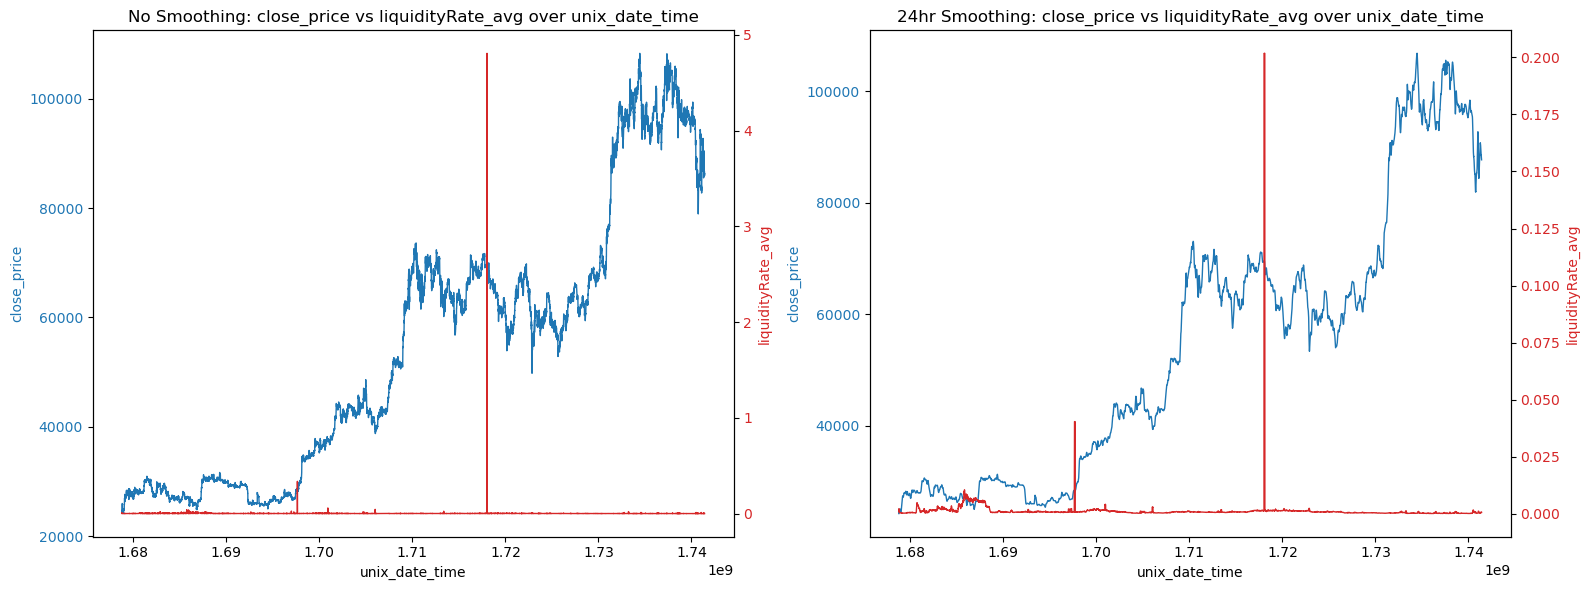

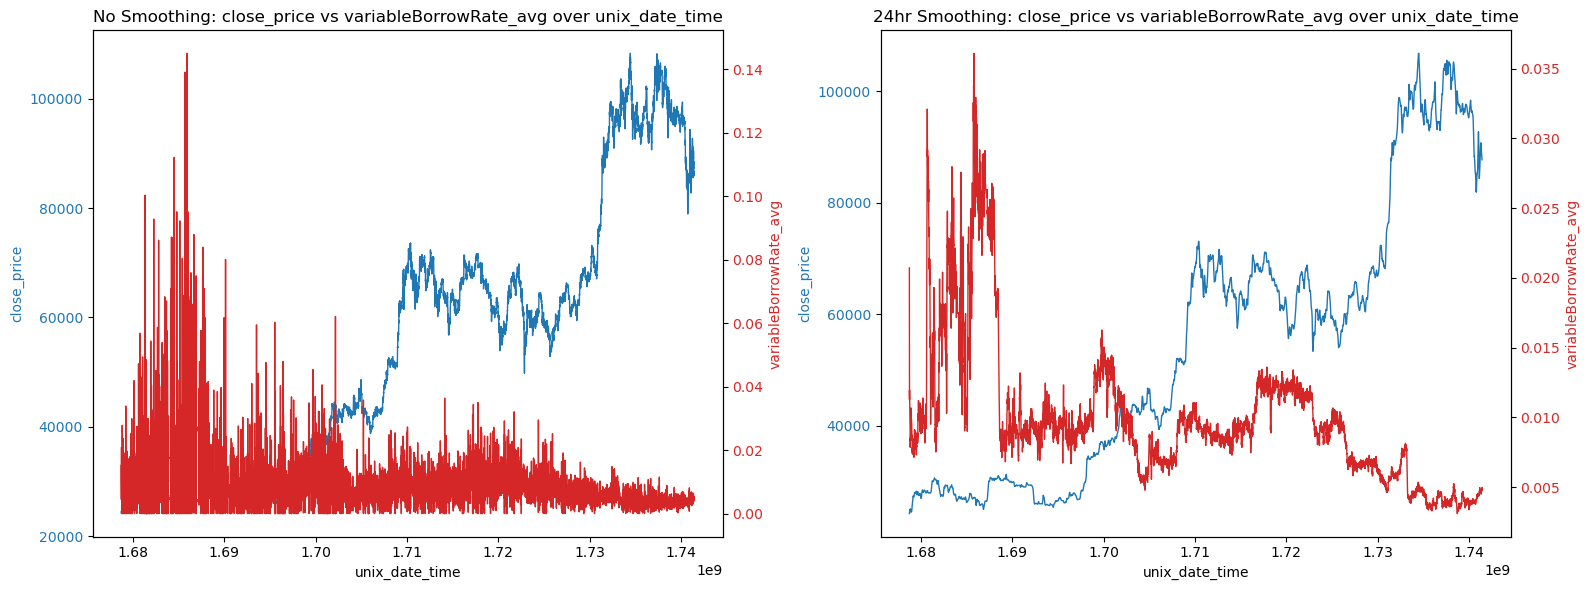

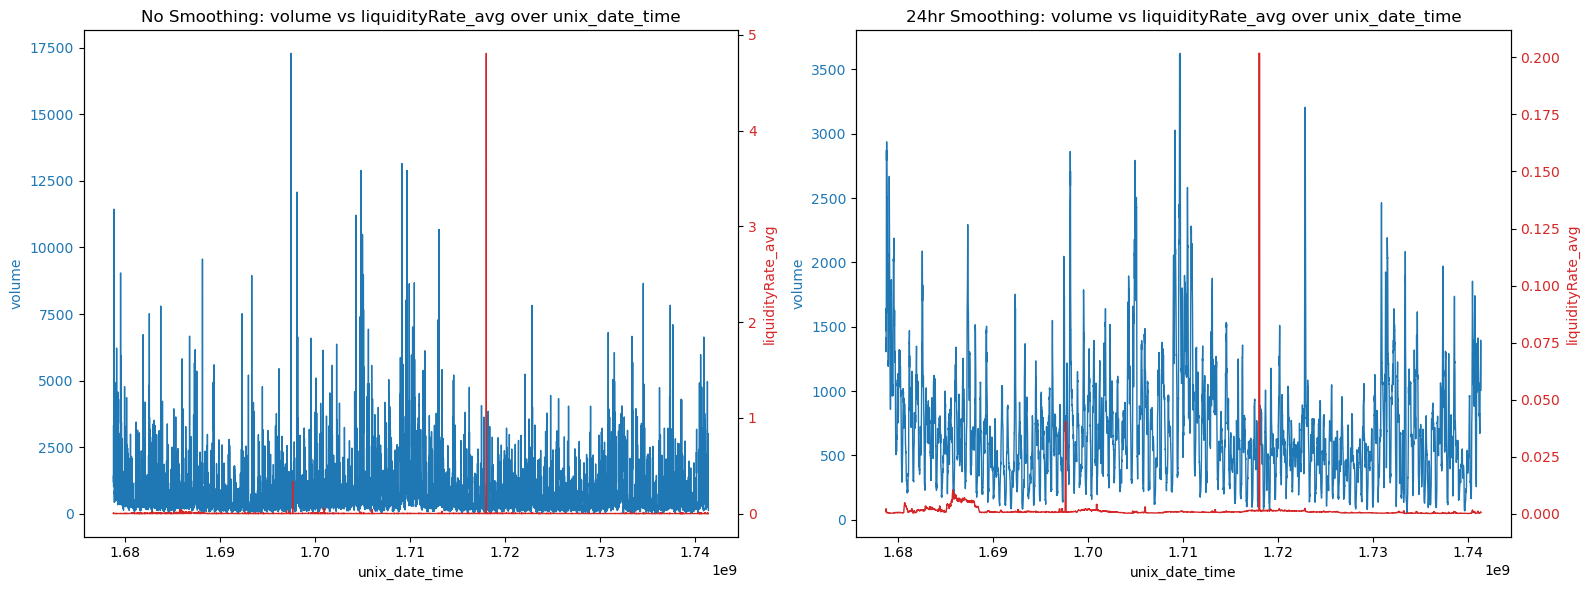

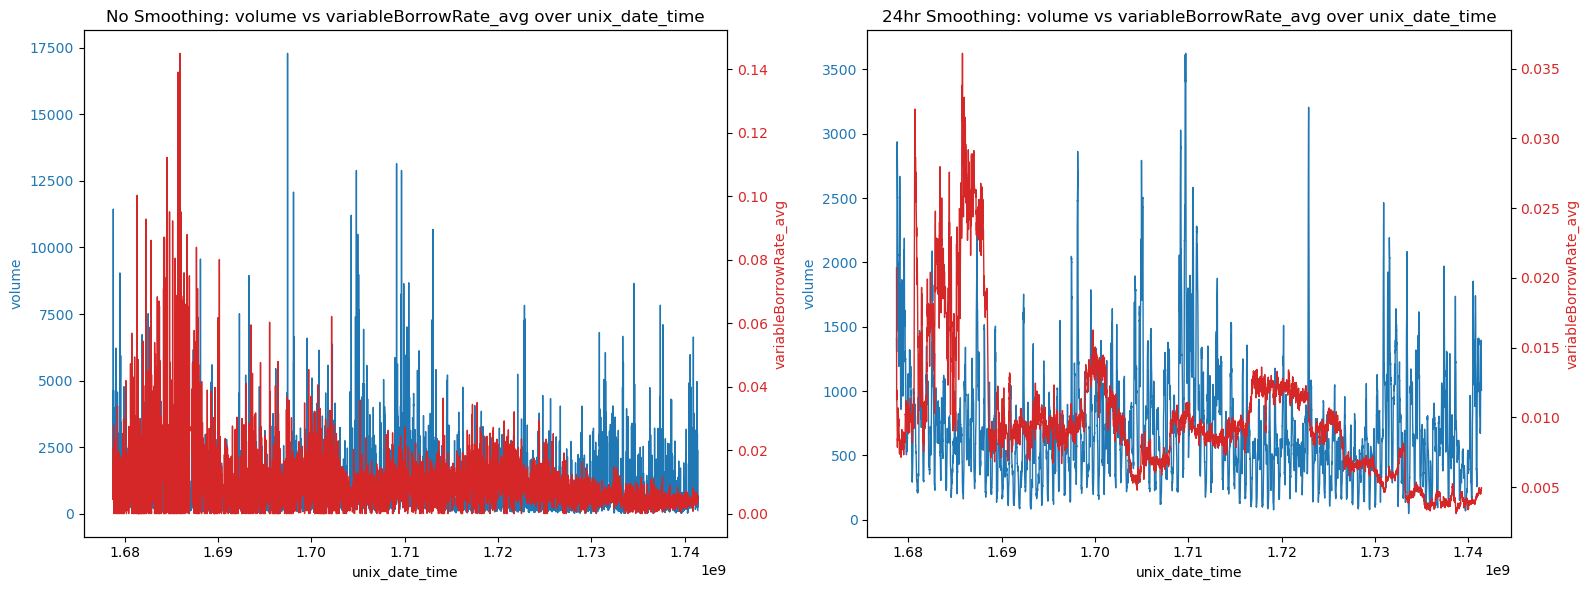

wrapped eth_core market


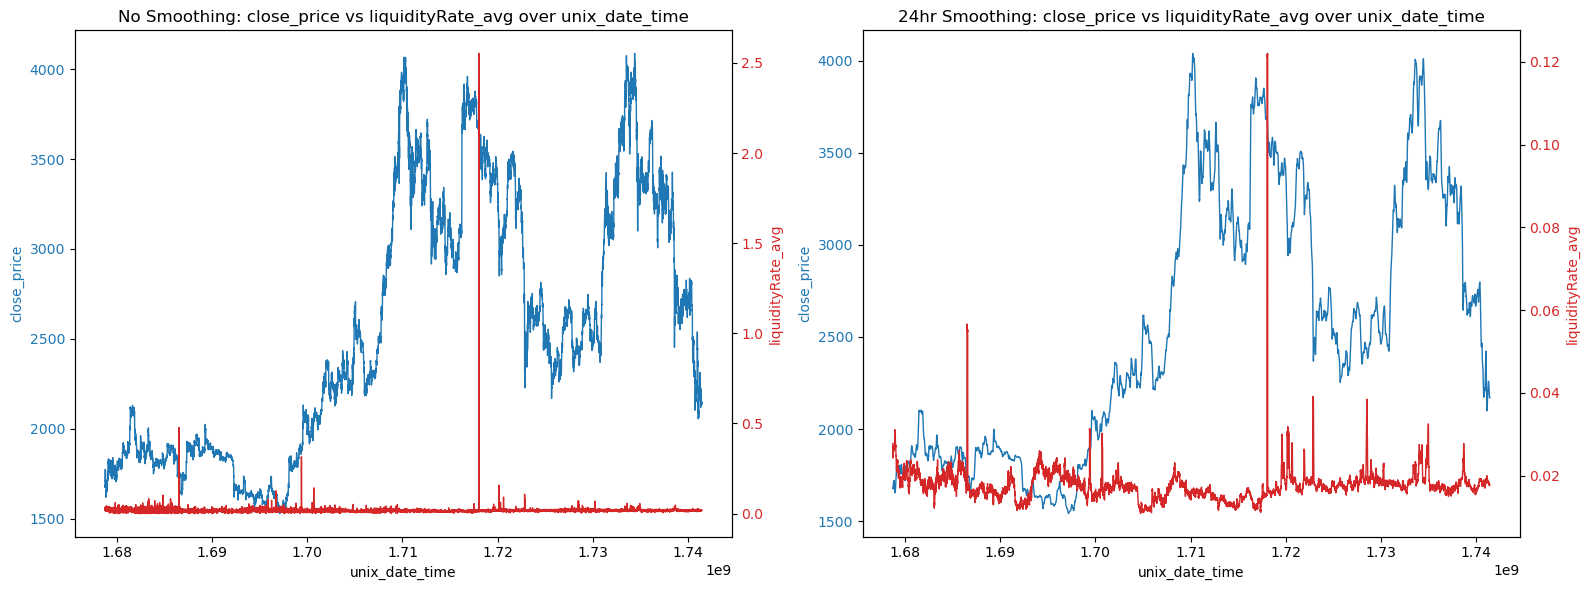

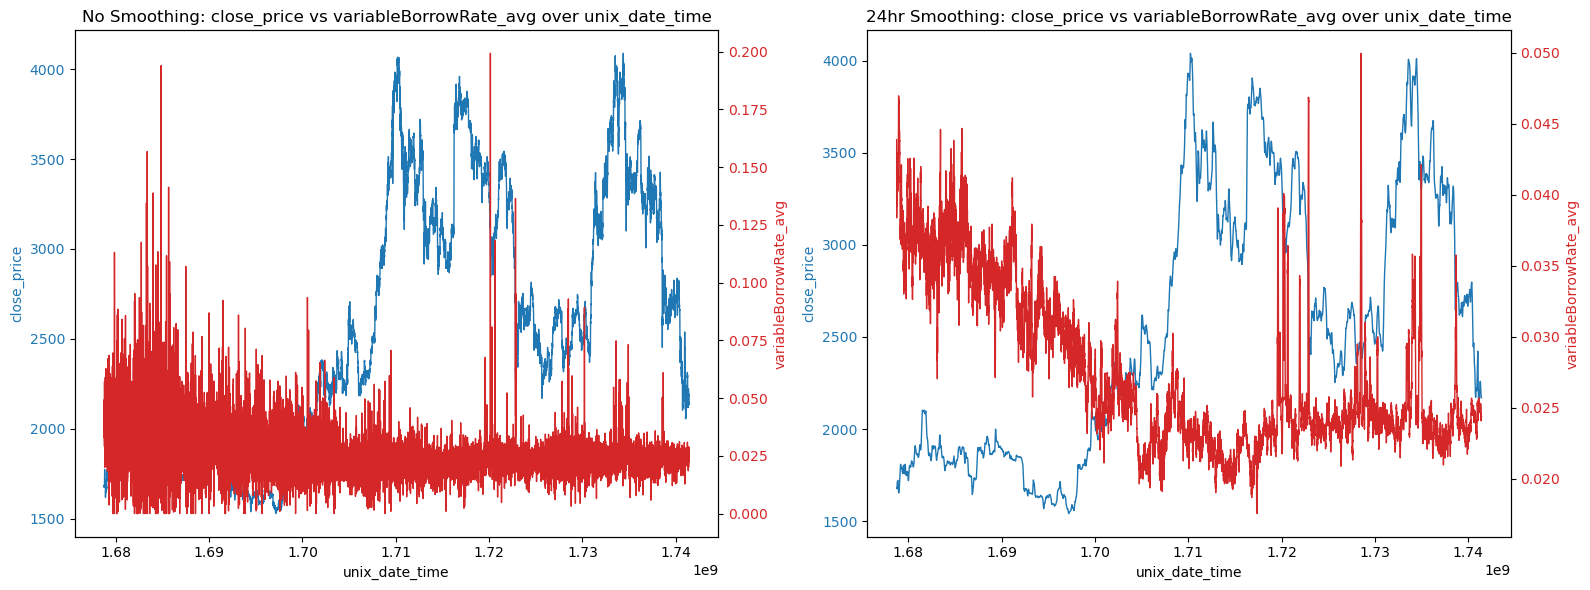

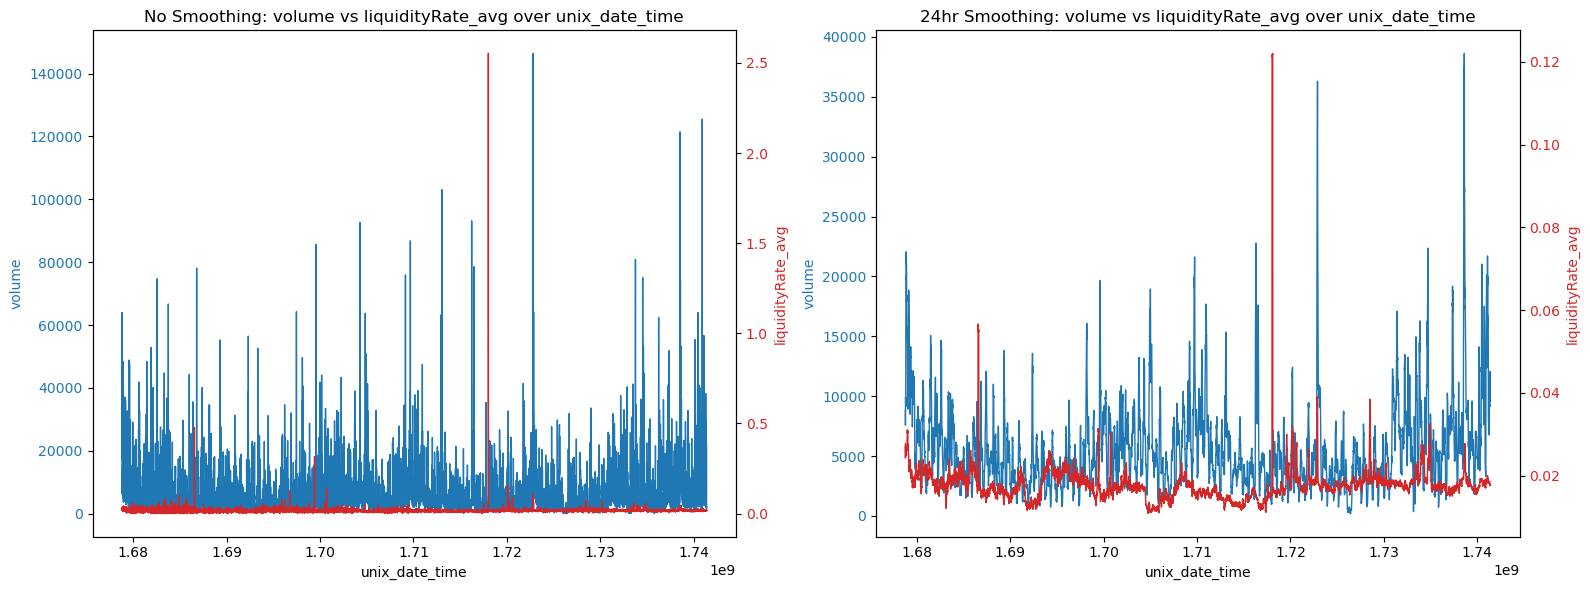

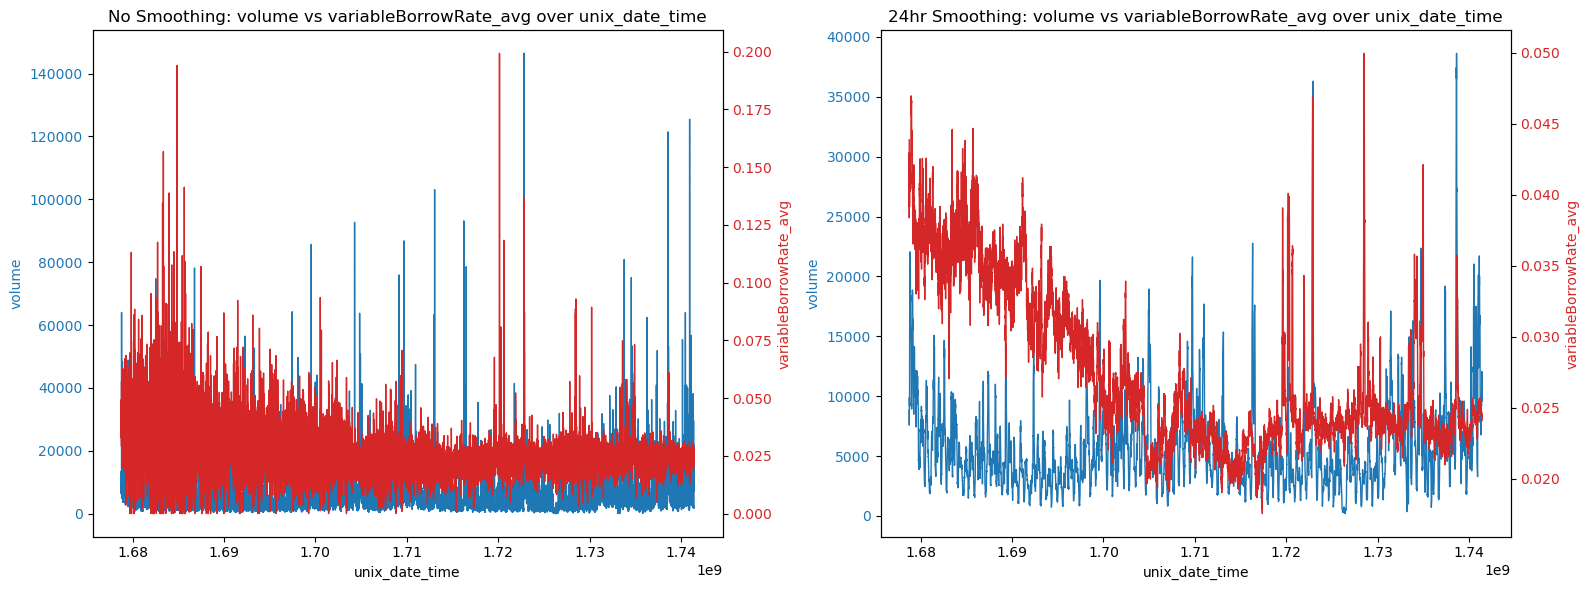

In [243]:
for core, polyio in df_pairs:
    core_df = core_crypto_dfs[core]
    polyio_df = polyio_dfs[polyio]
    combined_df = combine_on_unix_date_time(core_df, polyio_df)
    print(core)
    plot_dual_y_axis(combined_df, 'unix_date_time', 'close_price', 'liquidityRate_avg', 1, 24)
    plot_dual_y_axis(combined_df, 'unix_date_time', 'close_price', 'variableBorrowRate_avg', 1, 24)
    plot_dual_y_axis(combined_df, 'unix_date_time', 'volume', 'liquidityRate_avg', 1, 24)
    plot_dual_y_axis(combined_df, 'unix_date_time', 'volume', 'variableBorrowRate_avg', 1, 24)